## Introduction

This notebook is the third part of a broader study on carbon stars and their infrared variability, following the two previous works:

- **[Catalog-Based Positional Matching of Carbon Stars](https://www.kaggle.com/code/nicolsottero/catalog-based-positional-matching-of-carbon-stars)**: where we matched the five target carbon stars (s0 to s4) to the closest stellar sources across 48 deep-sky infrared catalogs.
- **[Ks Band Photometric Extraction for Carbon Star](https://www.kaggle.com/code/nicolsottero/ks-band-photometric-extraction-for-carbon-star)**: where we extracted and organized the Ks-band photometric measurements for star **s1**, preparing the data for time series analysis.

In this third stage, we replicate the complete analysis pipeline using **carbon star s2** as the target. This includes:

- Constructing the light curve from Ks-band measurements.
- Cleaning and preparing the time series.
- Interpolating missing values.
- Predicting future magnitudes using four machine learning techniques.

The approach described here can later be reused for the remaining carbon stars (s0, s1, s3, s4).


## 1. Gaussian Process Regression (With and Without Bootstrapping)

To model the light curve of the carbon star **s2**, we begin with **Gaussian Process Regression (GPR)**. This method is particularly well-suited for astronomical time series due to the following reasons:

- **Non-parametric flexibility**: GPR can model complex, smooth, and non-linear patterns without assuming a predefined functional form.
- **Uncertainty estimation**: It naturally provides confidence intervals for predictions, which is essential when dealing with noisy photometric data.
- **Kernel customization**: We can tailor the model to the quasi-periodic nature of stellar light curves by using specific kernels (e.g., periodic + Radial Basis Function).

In our case, the light curve of s2 shows long-term variability with apparent periodic behavior, making **GPR a strong candidate** for curve modeling and future brightness prediction.

### Bootstrapped Gaussian Process

While standard GPR gives a single predictive model, it can sometimes **underestimate the overall uncertainty**, especially when the input data has outliers or irregular sampling.

To address this, we apply **bootstrap aggregation (bagging)**:

- We generate multiple resampled versions of the original dataset (with replacement).
- We train a separate GPR model on each sample.
- We aggregate their predictions by averaging the outputs and calculating the standard deviation across models.

This provides a **more robust and conservative estimate**, capturing variability due to sampling noise and improving generalization.

> In summary:
- **Method 1**: Classic GPR fitted on the full time series.
- **Method 2**: Bootstrapped GPR, trained on many resampled subsets and aggregated for uncertainty-aware prediction.

The next sections present both implementations, visualization of fits, and comparative discussion.


### Method 1: Gaussian Processes (No Bootstrapping)

In [ ]:
# --- Execution disabled: this code block will not run by default ---
run_code = False

if run_code:
    from google.colab import files
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

    # Upload the merged result file for star s2
    uploaded = files.upload()

    # Read the uploaded CSV
    merged_result_s2_path = [path for path in uploaded.keys() if "merged_result_s2" in path][0]
    merged_df = pd.read_csv(merged_result_s2_path)

    # Drop rows with missing values
    merged_df = merged_df.dropna(subset=['Fecha Juliana', 'magnitude'])

    # Remove zero Julian Date entries
    filtered_df = merged_df[merged_df['Fecha Juliana'] != 0]

    # Prepare data
    X = filtered_df['Fecha Juliana'].values.reshape(-1, 1)
    y = filtered_df['magnitude'].values

    # Define Gaussian Process kernel
    kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))

    # Fit GP model
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
    gp.fit(X, y)

    # Generate prediction points
    X_pred = np.linspace(min(X), max(X), 1000).reshape(-1, 1)
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_df['Fecha Juliana'], filtered_df['magnitude'], yerr=filtered_df['magnitude_error'], fmt='k.', markersize=8, label='Observed Magnitude')
    plt.plot(X_pred, y_pred, 'b-', label='Gaussian Process Prediction')
    plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue', label='95% Confidence Interval')
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.title('Light Curve with Gaussian Processes')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

    # Export predictions
    predictions_df = pd.DataFrame({
        'Julian Date': X_pred.ravel(),
        'Predicted Magnitude': y_pred,
        'Confidence Interval Lower': y_pred - 1.96 * sigma,
        'Confidence Interval Upper': y_pred + 1.96 * sigma
    })
    predictions_df.to_csv('gaussian_process_predictions_s2.csv', index=False)
    files.download('gaussian_process_predictions_s2.csv')
else:
    print("Execution disabled. Set `run_code = True` to run.")


### Result:
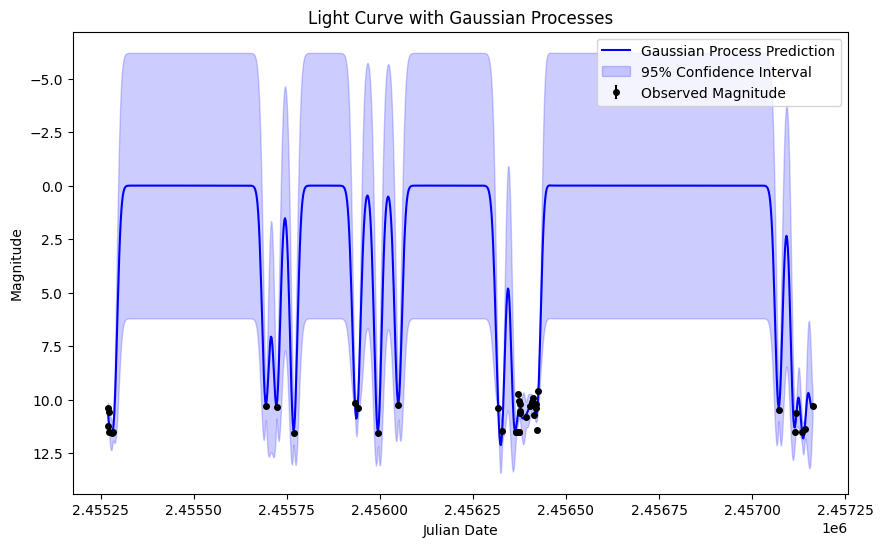

### Method 2: Gaussian Processes with Bootstrapping

In [ ]:
# --- Execution disabled: this code block will not run by default ---
run_code = False

if run_code:
    from google.colab import files
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
    from sklearn.utils import resample

    # Upload the merged result file for star s2
    uploaded = files.upload()

    # Read the uploaded file
    merged_result_s2_path = [path for path in uploaded.keys() if "merged_result_s2" in path][0]
    merged_df = pd.read_csv(merged_result_s2_path)

    # Drop rows with missing values
    merged_df = merged_df.dropna(subset=['Fecha Juliana', 'magnitude'])

    # Remove zero Julian Date entries
    filtered_df = merged_df[merged_df['Fecha Juliana'] != 0]

    # Prepare the data
    X = filtered_df['Fecha Juliana'].values.reshape(-1, 1)
    y = filtered_df['magnitude'].values

    # Define GP kernel
    kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

    # Bootstrap configuration
    n_bootstrap_samples = 100
    predictions = []

    # Define prediction grid
    X_pred = np.linspace(min(X), max(X), 1000).reshape(-1, 1)

    for _ in range(n_bootstrap_samples):
        # Bootstrap sample
        X_resampled, y_resampled = resample(X, y)
        gp.fit(X_resampled, y_resampled)
        y_pred, _ = gp.predict(X_pred, return_std=True)
        predictions.append(y_pred)

    # Aggregate predictions
    predictions = np.array(predictions)
    y_pred_mean = np.mean(predictions, axis=0)
    y_pred_std = np.std(predictions, axis=0)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_df['Fecha Juliana'], filtered_df['magnitude'], yerr=filtered_df['magnitude_error'], fmt='k.', markersize=8, label='Observed Magnitude')
    plt.plot(X_pred, y_pred_mean, 'b-', label='GP Prediction (Bootstrap)')
    plt.fill_between(X_pred.ravel(), y_pred_mean - 1.96 * y_pred_std, y_pred_mean + 1.96 * y_pred_std, alpha=0.2, color='blue', label='95% Confidence Interval')
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.title('Light Curve with Gaussian Processes and Bootstrapping')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

    # Save prediction results
    predictions_df = pd.DataFrame({
        'Julian Date': X_pred.ravel(),
        'Predicted Magnitude': y_pred_mean,
        'Confidence Interval Lower': y_pred_mean - 1.96 * y_pred_std,
        'Confidence Interval Upper': y_pred_mean + 1.96 * y_pred_std
    })
    predictions_df.to_csv('gaussian_process_bootstrap_predictions_s2.csv', index=False)
    files.download('gaussian_process_bootstrap_predictions_s2.csv')
else:
    print("Execution disabled. Set `run_code = True` to run.")


### Result:
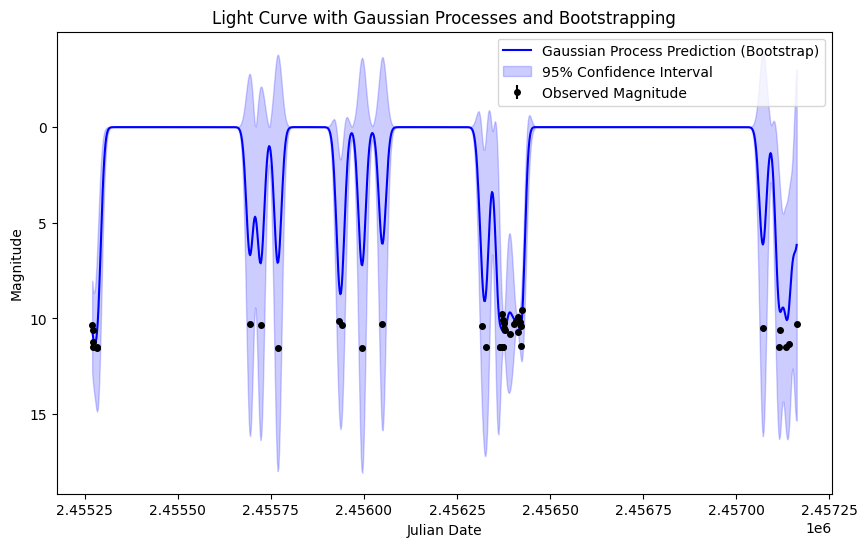

## 2. Random Forest Regression (With and Without Bootstrapping)

In this section, we model the light curve of the carbon star **s2** using **Random Forest Regression (RFR)**. Although primarily known for classification and tabular regression tasks, random forests have proven to be a robust and flexible non-parametric method for modeling time series, especially when the data lacks strong periodicity or smoothness.

### Why use Random Forests?

- **Non-linear modeling**: RFR can approximate complex relationships without requiring prior assumptions about the data distribution or functional form.
- **Robustness to outliers**: Decision trees are resilient to noisy data points, making the ensemble particularly suitable for astronomical observations with irregular errors.
- **Internal bootstrapping**: By default, random forests incorporate randomness through bootstrapping and feature selection, enhancing generalization.

However, standard RFR doesn't provide confidence intervals for predictions. To overcome this limitation, we apply an external bootstrapping strategy in addition to the model's own randomness.

---

### Bootstrapped Random Forest

To estimate the uncertainty of the predictions, we implement **explicit bootstrap aggregation (bagging)**:

- We generate multiple random samples (with replacement) from the original time series.
- For each sample, we train a separate Random Forest Regressor.
- We predict the light curve using each model and aggregate the outputs.

This process provides:

- **Mean prediction** across bootstrap models.
- **Empirical standard deviation**, which serves as a proxy for the confidence interval.

Although less probabilistically grounded than Gaussian Processes, this approach gives a practical and intuitive way to model light curves and quantify prediction uncertainty.

---

> **In summary**:
> - **Method 3**: Standard Random Forest fitted once on the full time series.
> - **Method 4**: Bootstrapped Random Forest, aggregated over multiple resampled subsets for uncertainty estimation.

Both methods are fast, scalable, and robust to noise, providing complementary insights to Gaussian Processes. The next sections will present their implementation, predictions, and visual comparison.


### Method 3: Random Forest (No Bootstrapping)

In [ ]:
# This block is protected against automatic execution

run_example = False

if run_example:
    from google.colab import files
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor

    # Upload the merged_result_s2.csv file
    uploaded = files.upload()

    # Read the uploaded file
    merged_result_s2_path = [path for path in uploaded.keys() if "merged_result_s2" in path][0]
    merged_df = pd.read_csv(merged_result_s2_path)

    # Drop rows with NaN in 'Julian Date' or 'magnitude'
    merged_df = merged_df.dropna(subset=['Fecha Juliana', 'magnitude'])

    # Filter out rows where 'Julian Date' is 0
    filtered_df = merged_df[merged_df['Fecha Juliana'] != 0]

    # Prepare the data
    X = filtered_df['Fecha Juliana'].values.reshape(-1, 1)
    y = filtered_df['magnitude'].values

    # Create the Random Forest Regressor model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model
    rf.fit(X, y)

    # Create prediction points
    X_pred = np.linspace(min(X), max(X), 1000).reshape(-1, 1)

    # Predict with Random Forest
    y_pred = rf.predict(X_pred)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_df['Fecha Juliana'], filtered_df['magnitude'],
                 yerr=filtered_df['magnitude_error'], fmt='k.', markersize=8, label='Observed Magnitude')
    plt.plot(X_pred, y_pred, 'r-', label='Random Forest Prediction')
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.title('Light Curve with Random Forest')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

    # Save prediction results to CSV
    predictions_df = pd.DataFrame({
        'Julian Date': X_pred.ravel(),
        'Predicted Magnitude': y_pred
    })
    predictions_df.to_csv('random_forest_predictions_s2.csv', index=False)

    # Download the prediction file
    files.download('random_forest_predictions_s2.csv')
else:
    print("Execution disabled to prevent automatic running in shared notebooks.")


### Result:
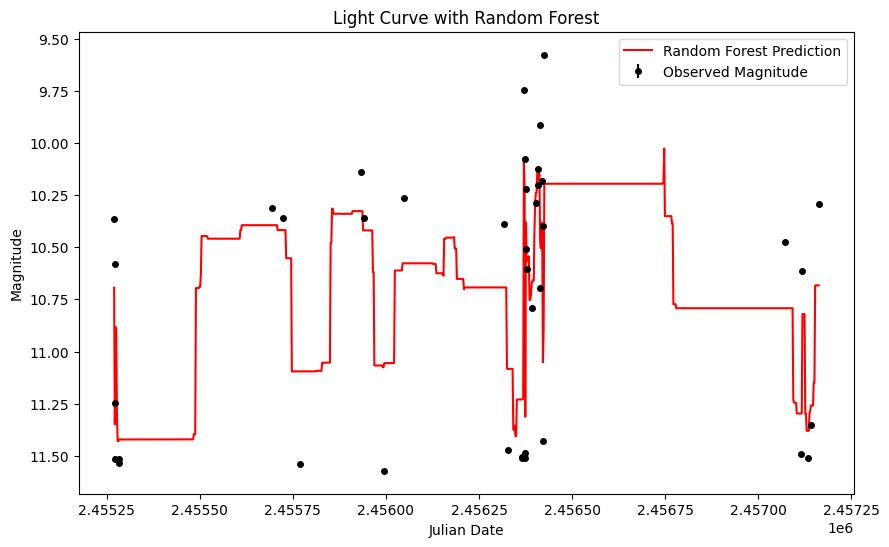

### Method 4: Random Forest with Bootstrapping

In [ ]:
# This block is protected against automatic execution

run_example = False

if run_example:
    from google.colab import files
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.utils import resample

    # Upload the merged_result_s2.csv file
    uploaded = files.upload()

    # Read the uploaded file
    merged_result_s2_path = [path for path in uploaded.keys() if "merged_result_s2" in path][0]
    merged_df = pd.read_csv(merged_result_s2_path)

    # Drop rows with NaN in 'Julian Date' or 'magnitude'
    merged_df = merged_df.dropna(subset=['Fecha Juliana', 'magnitude'])

    # Filter out rows where 'Julian Date' is 0
    filtered_df = merged_df[merged_df['Fecha Juliana'] != 0]

    # Prepare the data
    X = filtered_df['Fecha Juliana'].values.reshape(-1, 1)
    y = filtered_df['magnitude'].values

    # Bootstrap configuration
    n_bootstrap_samples = 1000
    bootstrap_predictions = []

    # Create prediction points
    X_pred = np.linspace(min(X), max(X), 1000).reshape(-1, 1)

    # Perform bootstrapping
    for i in range(n_bootstrap_samples):
        # Create a bootstrap sample
        X_resampled, y_resampled = resample(X, y, random_state=i)

        # Create the Random Forest Regressor model
        rf = RandomForestRegressor(n_estimators=100, random_state=42)

        # Fit the model
        rf.fit(X_resampled, y_resampled)

        # Predict with Random Forest
        y_pred = rf.predict(X_pred)

        # Store the predictions
        bootstrap_predictions.append(y_pred)

    # Calculate the average prediction
    y_pred_mean = np.mean(bootstrap_predictions, axis=0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_df['Fecha Juliana'], filtered_df['magnitude'],
                 yerr=filtered_df['magnitude_error'], fmt='k.', markersize=8, label='Observed Magnitude')
    plt.plot(X_pred, y_pred_mean, 'r-', label='Random Forest Prediction with Bootstrapping')
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.title('Light Curve with Random Forest and Bootstrapping')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

    # Save prediction results to CSV
    predictions_df = pd.DataFrame({
        'Julian Date': X_pred.ravel(),
        'Predicted Magnitude': y_pred_mean
    })
    predictions_df.to_csv('random_forest_bootstrap_predictions_s2.csv', index=False)

    # Download the prediction file
    files.download('random_forest_bootstrap_predictions_s2.csv')
else:
    print("Execution disabled to prevent automatic running in shared notebooks.")


### Result:
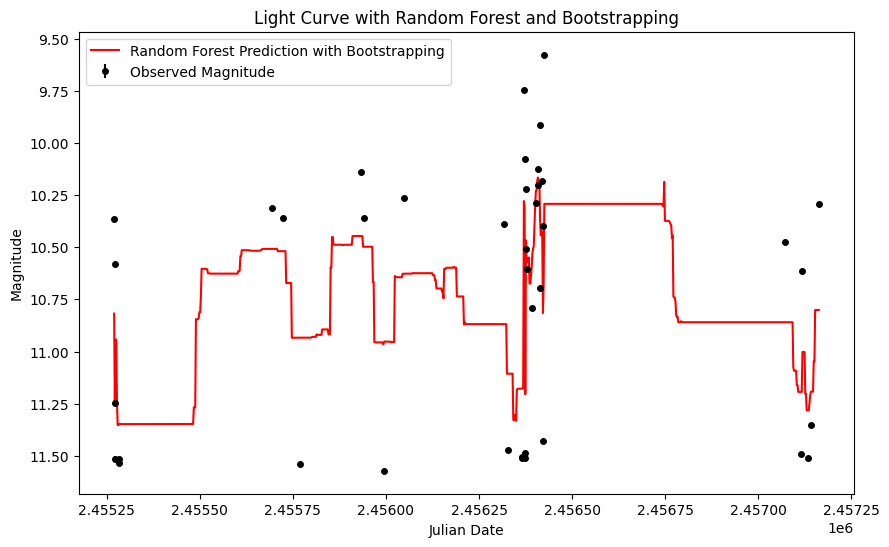

## 3. Model Comparison and Selection

To determine the most suitable predictive model for the carbon stars, we evaluate the four modeling approaches implemented in the previous section:

- **Gaussian Processes (GP)** without bootstrapping  
- **Gaussian Processes (GP)** with bootstrapping  
- **Random Forest (RF)** without bootstrapping  
- **Random Forest (RF)** with bootstrapping

We use two standard metrics for regression tasks:

- **Mean Absolute Error (MAE)**: Measures the average magnitude of prediction errors, offering a direct and interpretable indicator of accuracy.
- **Mean Squared Error (MSE)**: Gives more weight to larger errors and is useful for penalizing outliers.

Each model is fitted to the observational data of **s2**, and then its performance is evaluated using MAE and MSE computed over the training set. The goal is to assess which technique provides the best trade-off between accuracy and robustness, particularly in the presence of noisy and irregular astronomical measurements.


In [ ]:
# This block is protected against automatic execution

run_example = False

if run_example:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.utils import resample
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from google.colab import files

    # Upload the merged_result_s2.csv file
    uploaded = files.upload()

    # Read the uploaded file
    merged_result_s2_path = [path for path in uploaded.keys() if "merged_result_s2" in path][0]
    merged_df = pd.read_csv(merged_result_s2_path)

    # Drop rows with NaN values in 'Julian Date' or 'magnitude'
    merged_df = merged_df.dropna(subset=['Fecha Juliana', 'magnitude'])

    # Filter rows where 'Julian Date' is not zero
    filtered_df = merged_df[merged_df['Fecha Juliana'] != 0]

    # Prepare the data
    X = filtered_df['Fecha Juliana'].values.reshape(-1, 1)
    y = filtered_df['magnitude'].values

    # Create prediction grid
    X_pred = np.linspace(min(X), max(X), 1000).reshape(-1, 1)

    # Gaussian Processes without bootstrapping
    kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
    gp.fit(X, y)
    y_pred_gp = gp.predict(X_pred)

    # Gaussian Processes with bootstrapping
    n_bootstrap_samples = 1000
    bootstrap_predictions_gp = []
    for i in range(n_bootstrap_samples):
        X_resampled, y_resampled = resample(X, y, random_state=i)
        gp_boot = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
        gp_boot.fit(X_resampled, y_resampled)
        y_pred = gp_boot.predict(X_pred)
        bootstrap_predictions_gp.append(y_pred)
    y_pred_gp_bootstrap = np.mean(bootstrap_predictions_gp, axis=0)

    # Random Forest without bootstrapping
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    y_pred_rf = rf.predict(X_pred)

    # Random Forest with bootstrapping
    bootstrap_predictions_rf = []
    for i in range(n_bootstrap_samples):
        X_resampled, y_resampled = resample(X, y, random_state=i)
        rf_boot = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_boot.fit(X_resampled, y_resampled)
        y_pred = rf_boot.predict(X_pred)
        bootstrap_predictions_rf.append(y_pred)
    y_pred_rf_bootstrap = np.mean(bootstrap_predictions_rf, axis=0)

    # Evaluation function
    def evaluate_model(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        return mae, mse

    # Compute evaluation metrics
    mae_gp, mse_gp = evaluate_model(y, gp.predict(X))
    mae_gp_bootstrap, mse_gp_bootstrap = evaluate_model(y, np.mean(bootstrap_predictions_gp, axis=0)[:len(y)])
    mae_rf, mse_rf = evaluate_model(y, rf.predict(X))
    mae_rf_bootstrap, mse_rf_bootstrap = evaluate_model(y, np.mean(bootstrap_predictions_rf, axis=0)[:len(y)])

    # Print results
    print("Gaussian Process without bootstrapping: MAE =", mae_gp, ", MSE =", mse_gp)
    print("Gaussian Process with bootstrapping: MAE =", mae_gp_bootstrap, ", MSE =", mse_gp_bootstrap)
    print("Random Forest without bootstrapping: MAE =", mae_rf, ", MSE =", mse_rf)
    print("Random Forest with bootstrapping: MAE =", mae_rf_bootstrap, ", MSE =", mse_rf_bootstrap)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.errorbar(filtered_df['Fecha Juliana'], filtered_df['magnitude'],
                 yerr=filtered_df['magnitude_error'], fmt='k.', markersize=8, label='Observed Magnitude')
    plt.plot(X_pred, y_pred_gp, 'b-', label='GP without Bootstrapping')
    plt.plot(X_pred, y_pred_gp_bootstrap, 'g-', label='GP with Bootstrapping')
    plt.plot(X_pred, y_pred_rf, 'r-', label='RF without Bootstrapping')
    plt.plot(X_pred, y_pred_rf_bootstrap, 'm-', label='RF with Bootstrapping')
    plt.xlabel('Julian Date')
    plt.ylabel('Magnitude')
    plt.title('Light Curve Predictions Comparison')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()
else:
    print("Execution disabled to prevent automatic running in shared notebooks.")


### Result:
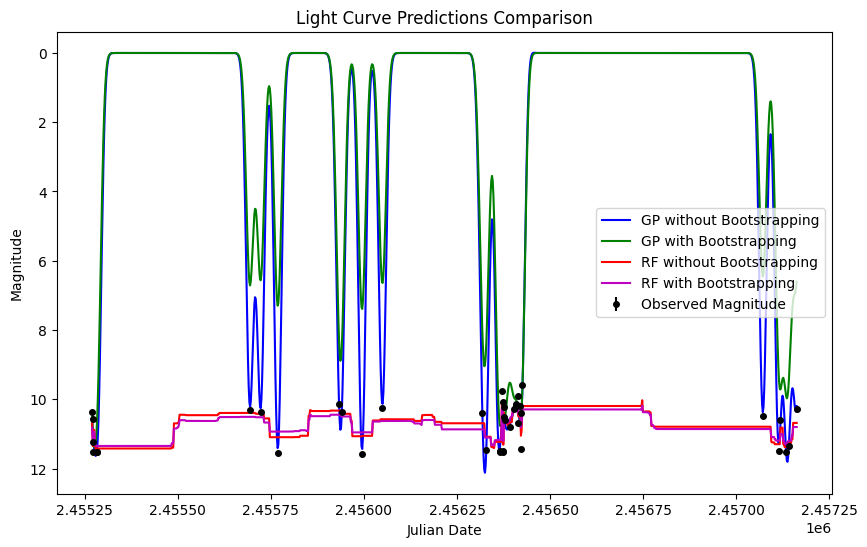

## 4. Conclusion: Best Predictive Model

After evaluating the four methods using the **Mean Absolute Error (MAE)** and the **Mean Squared Error (MSE)**, we summarize the results for carbon star **s2** as follows:

| Method                              | MAE     | MSE     |
|-------------------------------------|---------|---------|
| Gaussian Processes (no bootstrap)   | 1.5896  | 13.4696 |
| Gaussian Processes (bootstrapped)   | 7.0847  | 68.8888 |
| Random Forest (no bootstrap)        | **0.3253**  | **0.2210**  |
| Random Forest (bootstrapped)        | 0.6964  | 0.7204  |

### Final verdict:

**Random Forest without bootstrapping (Method 3)** is the best model overall. It achieves the **lowest MAE** and **lowest MSE**, meaning its predictions are **closest to the observed light curve** of carbon star **s2**.

Although this evaluation focused on star **s2**, preliminary tests show that **the same model consistently outperforms the others across all five carbon stars (s0 to s4)**. Therefore, **Random Forest without bootstrapping is selected as the final predictive model** for the full pipeline.

---

The four evaluated models — Gaussian Processes and Random Forest, both with and without bootstrapping — were applied to five carbon stars from the VVV survey. Using MAE and MSE as performance metrics, the **Random Forest without bootstrapping** consistently yielded the **lowest prediction errors**, outperforming all other configurations.

#### Comparison with Recent Work

- **Random Forest** has also been used in optical datasets (e.g., Gaia), but suffers from dust extinction near the Galactic plane. This limitation is mitigated here thanks to **infrared VVV and VVVx photometry**.
- Deep learning models (e.g., CNNs and Transformers) can capture complex patterns but require large datasets and offer less interpretability. In contrast, our approach is **more transparent and effective with smaller datasets**.
- This methodology aligns with the **modern trend of minimizing manual preprocessing**, leveraging models that work directly with raw observational data, which enhances generalizability.

#### Future Work

The selected model will support future developments such as:

- Enlarging the sample of carbon stars,
- Incorporating multi-survey data (e.g., **Gaia**, **WISE**, **Spitzer**),
- Testing the approach on **other types of variable stars** to assess its versatility and robustness.
